# Alpha Vantage Data Analysis
An analysis of stock data from Alpha Vantage. Below, a specific stock is chosen.

In [101]:
ticker = 'AAPL'

Now, data is donwloaded for the stock and saved. Remember that Alpha Vantage has a limited amount of calls per day and minute!

In [102]:
import save_data_to_csv

save_data_to_csv.save_dataset(ticker)

## Adjusted Price and Volume Graphs
The data is imported from where it is saved and plotted.

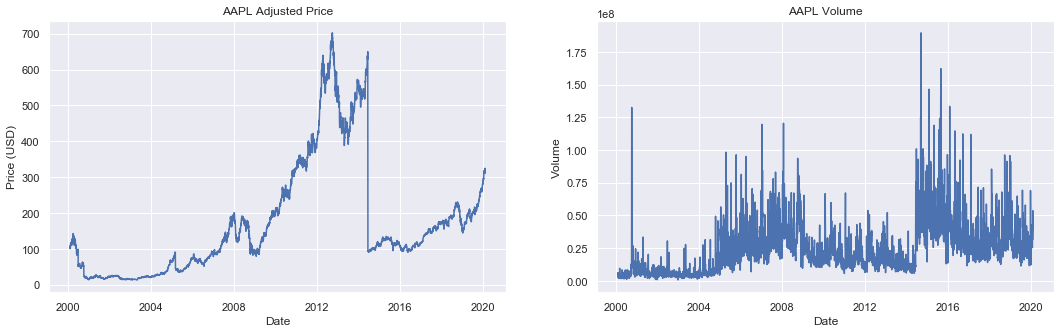

In [103]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Get data and make a datetime index
data = pd.read_csv(f'./Stock Data/{ticker}_daily_adjusted.csv')
data.set_index(pd.to_datetime(data['date']), inplace=True)
data.drop(columns='date', inplace=True)

# Make graphs
fig, ax = plt.subplots(1, 2, figsize=(18, 5))

ax[0].plot(data.index, data.loc[:, '1. open'])
ax[0].set_title(ticker + ' Adjusted Price')
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Price (USD)')

ax[1].plot(data.index, data.loc[:, '6. volume'])
ax[1].set_title(ticker + ' Volume')
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Volume');

## Technical Indicators
Techincal indicators are downloaded.

In [104]:
import save_ti_to_csv

save_ti_to_csv.save_ti(ticker)

Tehnical indicators are added to the data and plotted.

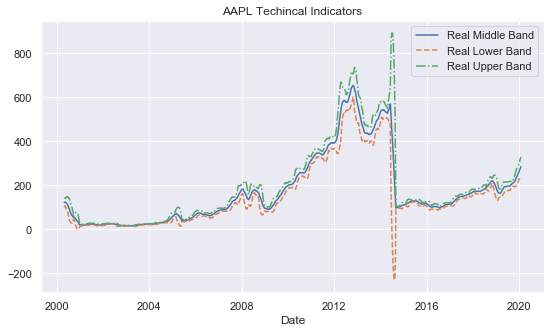

In [105]:
# Technical indicators added
ti = pd.read_csv(f'./Stock Data/{ticker}_daily_ti.csv')
ti.set_index(pd.to_datetime(ti['date']), inplace=True)
ti.drop(columns='date', inplace=True)
data = data.join(ti, on='date').dropna()
data.sort_index(inplace=True)

# Technical indicators plotted
plt.figure(figsize=(9, 5))
plt.plot(data.index, data['Real Middle Band'], label='Real Middle Band')
plt.plot(data.index, data['Real Lower Band'], label='Real Lower Band',
         linestyle='--')
plt.plot(data.index, data['Real Upper Band'], label='Real Upper Band',
         linestyle='-.')
plt.xlabel('Date')
plt.title(ticker + ' Techincal Indicators')
plt.legend();

## Predictive Modeling
Here, preditive modeling is perfromed on the data.
### Preprocessing
The data is preprocessed.

In [106]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# Number of historical points needed to make next prediction
hist_num = 50

# Get data in an array without dates
X = data.sort_index().values

# Make array of labels
y = np.array([X[:, 4][i + hist_num] for i in range(X.shape[0] - hist_num)])
y = np.expand_dims(y, -1)

# Normalize data
scaler = StandardScaler()
X = scaler.fit_transform(X)
yscaler = StandardScaler()
y = yscaler.fit_transform(y)

# Get data ready for model. Model should make a predicton based on hist_num observations.
X = np.array([X[i:i+hist_num] for i in range(X.shape[0] - hist_num)])

# Make sure we have the same amount of labels as observations
assert(y.shape[0] == X.shape[0])

# Split data into testing and training
test_perc = .2
n = int(X.shape[0]*(1 - test_perc))
Xtrain = X[:n]
Xtest = X[n:]
ytrain = y[:n]
ytest = y[n:]

### Modeling
A LSTM nerual network is trained.

In [112]:
import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,\
LSTM, Input, Activation, concatenate
from tensorflow.keras import optimizers
np.random.seed(4)
from tensorflow.compat.v1 import set_random_seed
set_random_seed(4)
from tensorflow.keras.callbacks import EarlyStopping

# Build model
model = Sequential()
model.add(Input(shape=(hist_num, X.shape[2]), name='lstm_input'))
model.add(LSTM(hist_num, name='lstm_0'))
model.add(Dropout(0.2, name='lstm_dropout_0'))
model.add(Dense(64, name='dense_0'))
model.add(Activation('sigmoid', name='sigmoid_0'))
model.add(Dense(1, name='dense_1'))
model.add(Activation('linear', name='linear_output'))

model.compile(optimizer='adam', loss='mse')

# Train model
es = EarlyStopping('val_loss', patience=5)
fit = model.fit(x=Xtrain, y=ytrain, batch_size=400, epochs=50,
          shuffle=True, validation_split=0.1, verbose=1);

Train on 3545 samples, validate on 394 samples
Epoch 1/50
3545/3545 [==============================] - 4s 1ms/sample - loss: 0.8792 - val_loss: 0.2438
Epoch 2/50
3545/3545 [==============================] - 0s 31us/sample - loss: 0.1583 - val_loss: 0.7457
Epoch 3/50
3545/3545 [==============================] - 0s 31us/sample - loss: 0.0734 - val_loss: 0.8684
Epoch 4/50
3545/3545 [==============================] - 0s 30us/sample - loss: 0.0347 - val_loss: 0.7283
Epoch 5/50
3545/3545 [==============================] - 0s 28us/sample - loss: 0.0212 - val_loss: 0.7704
Epoch 6/50
3545/3545 [==============================] - 0s 27us/sample - loss: 0.0134 - val_loss: 0.8002
Epoch 7/50
3545/3545 [==============================] - 0s 28us/sample - loss: 0.0093 - val_loss: 0.7176
Epoch 8/50
3545/3545 [==============================] - 0s 28us/sample - loss: 0.0078 - val_loss: 0.6849
Epoch 9/50
3545/3545 [==============================] - 0s 27us/sample - loss: 0.0070 - val_loss: 0.6703
Epoch 10/

Here is a visualization of the fit history.

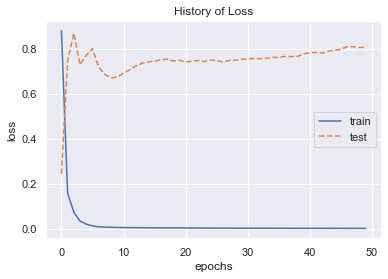

In [113]:
plt.plot(fit.history['loss'], label='train')
plt.plot(fit.history['val_loss'], '--', label='test',)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('History of Loss')
plt.legend();

### Evaluation
The model is evaluated on the test data.

In [114]:
evaluation = model.evaluate(Xtest, ytest, verbose=0)
print(f'The evaluation score is {evaluation}.')

The evaluation score is 2.526964189558465.


Now we plot the predicted price next to the actual.

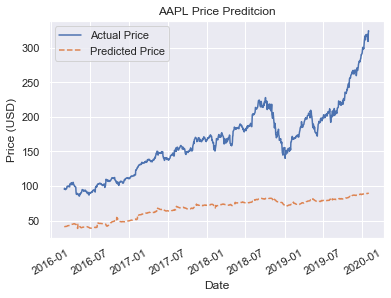

In [115]:
# Predict
ypred = model.predict(Xtest)

# Unnormalzie data
ypred = yscaler.inverse_transform(ypred)

# Graph
plt.plot(data.index[n+hist_num:], data.iloc[n+hist_num:, 4], label='Actual Price')
plt.plot(data.index[n+hist_num:], ypred, '--',
         label='Predicted Price')
plt.title(ticker + " Price Preditcion")
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.xticks(rotation=30)
plt.legend();

### Algorithmic Trading
The model is used to trade algorithmically.

In [111]:
# Make arrays to indicate whether to buy or sell
buy = np.zeros_like(ypred, dtype=bool)
sell = np.zeros_like(ypred, dtype=bool)
buy = buy.flatten()
sell = sell.flatten()


# Decide whether to buy or sell
for i in range(ypred.size - 1):
    
    if(ypred):
        if i == 0:
            buy[i] = True
        elif not buy[i - 1]:
            buy[i] = True
    else:
        if i != 0 & (not sell[i - 1]):
            sell[i] == True

# Visualize results
plt.plot(data.index[n+hist_num:], data.iloc[n+hist_num:, 4], label='Actual Price')
plt.scatter()

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()